### Install Necessary Libraries

A major reason for using Colab being the GPU, which is compulsory for running `daam` i.e. generating Diffusion Attentive Attribution Maps. Unfortunately, it requires python 3.10 so below are some steps to get python 3.10 up and running on Colab. Follow the intermediate instructions given in between cells. 

Instructions:
- Run the cell below, `Restart runtime`.
- Make sure you have selected `Python 3.10` in the `View Resources`>`Runtime type`>`Change runtime type` settings in Google Colab.
- Run the rest of the cells after the cell below (No need to re-run the below cell after restarting runtime). 

In [ ]:
!wget https://github.com/korakot/kora/releases/download/v0.10/py310.sh
!bash ./py310.sh -b -f -p /usr/local
!python -m ipykernel install --name "py310" --user

If everything is executed properly, you should see python `version: 3.10.6` below.

In [ ]:
import sys
print("version:", sys.version)

version: 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:35:26) [GCC 10.4.0]


Now, install the specific libraries for the task.
- `ipywidgets` sometimes require restarting runtime.

In [ ]:
!pip install -U daam -q
!pip install diffusers transformers gradio -q
!pip install scipy -q
!pip install ipywidgets==7.7.1
!pip install huggingface_hub

If you will be using Diffusion Models which would require token verification, run the cell below and input the token.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


Make sure you have `GPU` enabled.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f6b5db1c-2674-8aa0-bb8a-ba6aa1ab25a1)


Now, you are all set to work with generating images and attention maps.

### Importing Libraries

In [ ]:
import time

from daam import trace, set_seed, plot_overlay_heat_map, expand_image
from diffusers import StableDiffusionPipeline
from matplotlib import pyplot as plt
import torch

### Setting up the Pipeline

Below we set the Huggingface Pipeline for the Diffusion Model.
- `model_id`: Change it to the model id which you would be using. Some models require you to login and agree the terms of the model's repository on the huggingface website.
- `device`: Device on which the pipeline should be run `cuda` is needed for running `daam`.

In [ ]:
# model_id = 'prompthero/midjourney-v4-diffusion'
model_id = 'CompVis/stable-diffusion-v1-4'
device = 'cuda'

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Set Seed to get consistent results.

In [ ]:
gen = set_seed(0)

The following cell:
- Generates the image.
- Computes the Heat Map.
- Displays the generated image overlayed by the `daam` Heat Map for each word/token in the prompt.

In [ ]:
def generate(model_pipe, prompt):
  with torch.cuda.amp.autocast(dtype=torch.float16), torch.no_grad():
    with trace(model_pipe) as tc:

      # generate image
      out = model_pipe(prompt, num_inference_steps=30, generator=gen)

      # create heatmap
      heat_map = tc.compute_global_heat_map(prompt)
    
      for token in prompt.split():
    
        # showing image
        plt.axis('off')
        plt.clf()
        plot_overlay_heat_map(out.images[0], expand_image(heat_map.compute_word_heat_map(token)))
        plt.title(token)
        plt.show()

### Generating the Image

The prompt which would be used to generate the image.

In [ ]:
prompt = 'Chicken Fajita' 

Finally, let's look at the generated image and the heatmap associated with the prompt.

  0%|          | 0/32 [00:00<?, ?it/s]

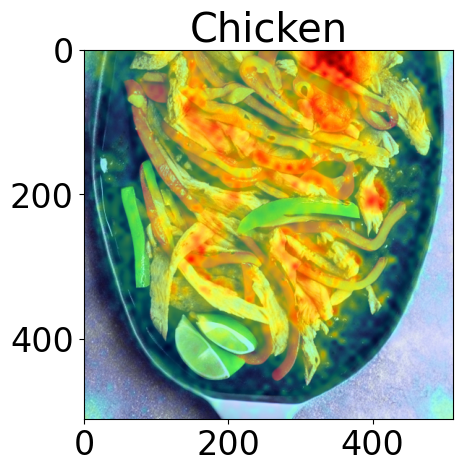

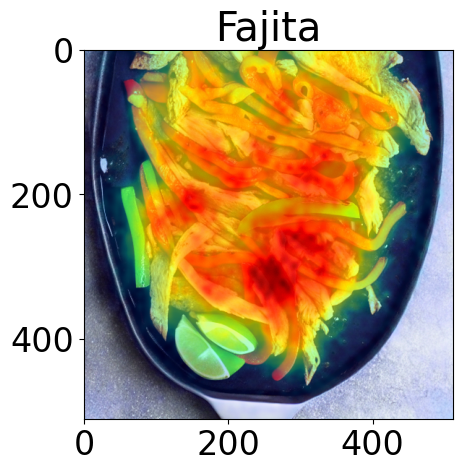

In [ ]:
generate(pipe, prompt)

#### A comparison between Diffusion Models

We see a comparison between some diffusion models below to choose the perfect tradeoff between latency time and generated image quality.

In [ ]:
prompts = [
  "A group of people stand in the back of a truck filled with cotton.",
  "A mother and three children collecting garbage from a blue and white garbage can on the street.",
  "A woman is sitting in a chair reading a book with her head resting on her free hand.",
  "A brown and white dog exiting a yellow and blue ramp in a grassy area.",
  "A boy stands on a rocky mountain."
  ]

In [ ]:
times = list()
for prompt in prompts:
  start = time.time()
  generate(pipe, prompt)
  end = time.time()
  times.append(end - start)

Now, let's see the time taken for generating the output corresponding to all these prompts.

In [ ]:
for i, prompt in enumerate(prompts):
  print(f'Prompt: {prompt}, Generation Time: {round(times[i], 3)}' )
print(f'Average generation time: {round(sum(times)/len(times), 3)}')

Prompt: A group of people stand in the back of a truck filled with cotton., Generation Time: 20.228
Prompt: A mother and three children collecting garbage from a blue and white garbage can on the street., Generation Time: 18.469
Prompt: A woman is sitting in a chair reading a book with her head resting on her free hand., Generation Time: 20.003
Prompt: A brown and white dog exiting a yellow and blue ramp in a grassy area., Generation Time: 19.776
Prompt: A boy stands on a rocky mountain., Generation Time: 15.533
Average generation time: 18.802


Trying out a different model.
- `CompVis/stable-diffusion-v1-1`

In [ ]:
model_id = 'CompVis/stable-diffusion-v1-1'
device = 'cuda'

pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/731 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/942 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/926 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/704 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [ ]:
times = list()
for prompt in prompts:
  start = time.time()
  generate(pipe, prompt)
  end = time.time()
  times.append(end - start)

In [ ]:
for i, prompt in enumerate(prompts):
  print(f'Prompt: {prompt}, Generation Time: {round(times[i], 3)}' )
print(f'Average generation time: {round(sum(times)/len(times), 3)}')

Prompt: A group of people stand in the back of a truck filled with cotton., Generation Time: 18.39
Prompt: A mother and three children collecting garbage from a blue and white garbage can on the street., Generation Time: 18.757
Prompt: A woman is sitting in a chair reading a book with her head resting on her free hand., Generation Time: 19.877
Prompt: A brown and white dog exiting a yellow and blue ramp in a grassy area., Generation Time: 19.682
Prompt: A boy stands on a rocky mountain., Generation Time: 15.659
Average generation time: 18.473


The recently released `stabilityai/stable-diffusion-base` model requires the following libraries to be installed. Restart runtime after installing and run the `Import Libraries` section (above) again to make sure we have the necessary libraries up and running.

In [ ]:
pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy

In [ ]:
from diffusers import StableDiffusionPipeline

In [ ]:
model_id = "stabilityai/stable-diffusion-2-base"
dev = 'cuda'

pipe = StableDiffusionPipeline.from_pretrained(model_id, revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to(dev)

Downloading:   0%|          | 0.00/475 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/340 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/820 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


`daam` module doesn't seem to support `stabilityai/stable-diffusion-2-base` yet (Can be seen below). So, we just look at the image generation times. Assuming heatmap generation time to be same as that of the above models, it runs $\sim 3$ seconds faster.

In [ ]:
generate(pipe, prompts[0])

  0%|          | 0/51 [00:00<?, ?it/s]

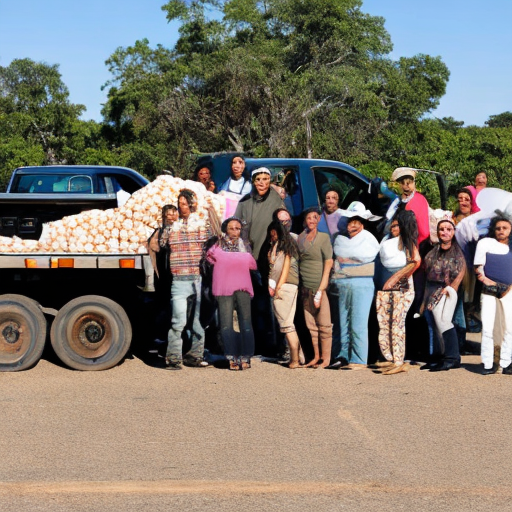

  0%|          | 0/51 [00:00<?, ?it/s]

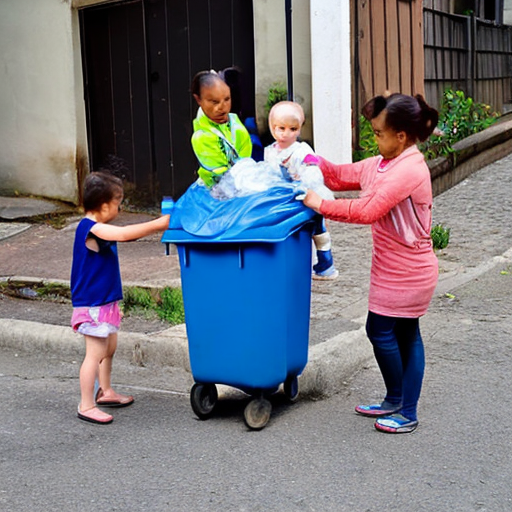

  0%|          | 0/51 [00:00<?, ?it/s]

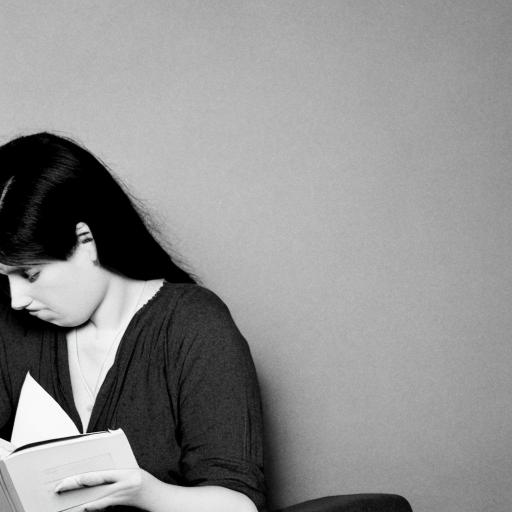

  0%|          | 0/51 [00:00<?, ?it/s]

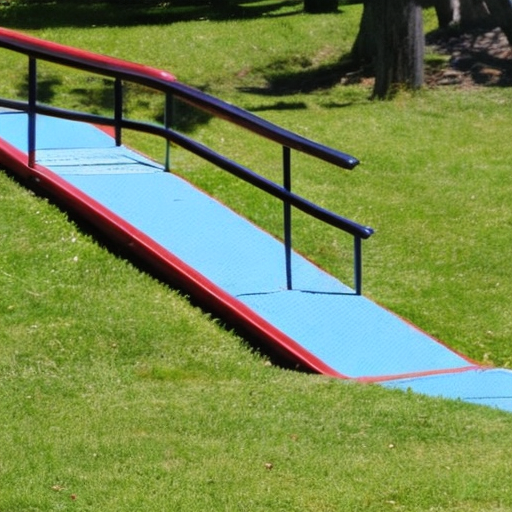

  0%|          | 0/51 [00:00<?, ?it/s]

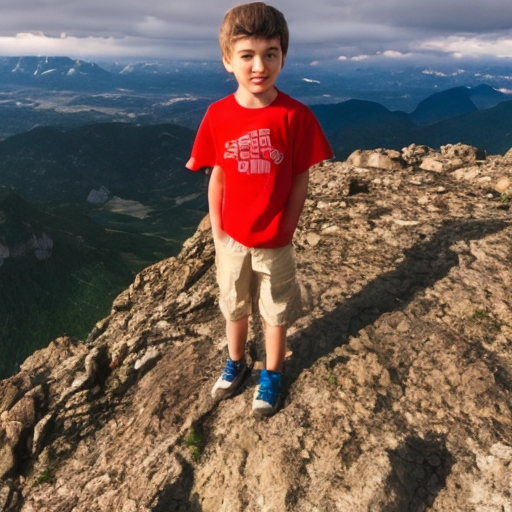

In [ ]:
times = list()
for prompt in prompts:
  start = time.time()
  display(pipe(prompt).images[0])
  end = time.time()
  times.append(end - start)

In [ ]:
for i, prompt in enumerate(prompts):
  print(f'Prompt: {prompt}, Generation Time: {round(times[i], 3)}' )
print(f'Average generation time: {round(sum(times)/len(times), 3)}')

Prompt: A group of people stand in the back of a truck filled with cotton., Generation Time: 8.797
Prompt: A mother and three children collecting garbage from a blue and white garbage can on the street., Generation Time: 8.608
Prompt: A woman is sitting in a chair reading a book with her head resting on her free hand., Generation Time: 8.698
Prompt: A brown and white dog exiting a yellow and blue ramp in a grassy area., Generation Time: 8.655
Prompt: A boy stands on a rocky mountain., Generation Time: 8.653
Average generation time: 8.682
